#### Most of the code used in this notebook was borrowed from the work published in the paper: [Deep Image Prior](https://arxiv.org/abs/1711.10925), and the code has been published to this link: https://github.com/DmitryUlyanov/deep-image-prior

In [1]:
"""
*Uncomment if running on colab*
Set Runtime -> Change runtime type -> Under Hardware Accelerator select GPU in Google Colab
"""
!git clone https://github.com/DmitryUlyanov/deep-image-prior
!mv deep-image-prior/* ./

Cloning into 'deep-image-prior'...
remote: Enumerating objects: 289, done.
remote: Total 289 (delta 0), reused 0 (delta 0), pack-reused 289
Receiving objects: 100% (289/289), 24.28 MiB | 30.00 MiB/s, done.
Resolving deltas: 100% (155/155), done.


In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import config as global_config

# Import libs

In [1]:
import cv2

In [2]:
from __future__ import print_function
import matplotlib.pyplot as plt
%matplotlib inline

import os

import numpy as np
from models.skip import skip
import torch
import torch.optim

from utils.inpainting_utils import *

torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark =True
dtype = torch.cuda.FloatTensor

# Choose figure

In [65]:
INFERENCE_DATA_PATH =global_config.INFERENCE_DATA_PATH #
MODEL_MASKS_IMGS_PATH = global_config.MODEL_MASKS_IMGS_PATH
STITCHED_IMGS_PATH = global_config.STITCHED_IMGS_PATH
INFERENCE_DATA_PATH = global_config.INFERENCE_DATA_PATH #
MODEL_CHECKPOINTS_PATH = global_config.MODEL_CHECKPOINTS_PATH

In [4]:
masks_paths = sorted(os.listdir(MODEL_MASKS_IMGS_PATH))
masks_paths = [i for i in masks_paths if '.jpg' in i]
print(masks_paths)

['0.jpg', '1.jpg', '10.jpg', '11.jpg', '12.jpg', '13.jpg', '14.jpg', '15.jpg', '16.jpg', '18.jpg', '2.jpg', '4.jpg', '5.jpg', '6.jpg', '7.jpg', '8.jpg', '9.jpg']


In [5]:
imgs_paths = sorted(os.listdir(STITCHED_IMGS_PATH))
print(imgs_paths)

['0.jpg', '1.jpg', '10.jpg', '11.jpg', '12.jpg', '13.jpg', '14.jpg', '15.jpg', '16.jpg', '17.jpg', '18.jpg', '19.jpg', '2.jpg', '3.jpg', '4.jpg', '5.jpg', '6.jpg', '7.jpg', '8.jpg', '9.jpg']


In [564]:
img_index = 16

In [565]:
img_path  = f"{STITCHED_IMGS_PATH}{img_index}.jpg"
mask_path = f"{MODEL_MASKS_IMGS_PATH}{img_index}.jpg"

# Load mask

In [566]:
img_pil, img_np = get_image(img_path, -1)
img_mask_pil, img_mask_np = get_image(mask_path, -1)

In [567]:
img_np.shape, img_mask_np.shape

((3, 2048, 4096), (1, 2048, 4096))

In [568]:
_, ORIGINAL_ROWS, ORIGINAL_COLUMNS = img_np.shape

In [572]:
img_np.shape, img_mask_np.shape

((3, 2048, 4096), (1, 2048, 4096))

In [573]:
img_mask_var = np_to_torch(img_mask_np).type(dtype)

# Setup

In [580]:
# Print a debug statement to indicate where the code execution is
print("we are here, in vase")

# Set the input depth for the neural network
input_depth = 2

# Set the learning rate for the optimizer
LR = 0.01

# Define the number of iterations for training
num_iter = 5001

# Set how often we want to display images during training
show_every = 50

# Define the figure size for plotting
figsize = 5

# Initialize the neural network using the 'skip' architecture
net = skip(input_depth, img_np.shape[0], num_channels_down = [64]*5,    num_channels_up   = [64]*5,   num_channels_skip = [0] * 5,
            upsample_mode='nearest', filter_skip_size=1, filter_size_up=3, filter_size_down=3,
            need_sigmoid=True, need_bias=True, pad='reflection', act_fun='LeakyReLU').type(dtype)

# Ensure the network is of the correct data type
net = net.type(dtype)

we are here, in vase


In [582]:
# calculates the number of parameters
s  = sum(np.prod(list(p.size())) for p in net.parameters())
print ('Number of params: %d' % s)

# Loss
mse = torch.nn.MSELoss().type(dtype)

img_var = np_to_torch(img_np).type(dtype)
mask_var = np_to_torch(img_mask_np).type(dtype)

Number of params: 542403


In [584]:

from torchvision import transforms as T
transform = T.Compose([ T.Resize((512, 1024))  ])

In [585]:
img_var, mask_var = transform(img_var), transform(mask_var)

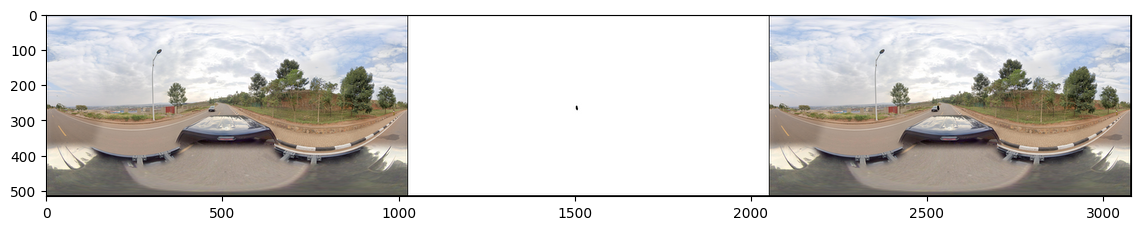

In [586]:
plot_image_grid([torch_to_np(img_var),
                 torch_to_np(mask_var),
                 torch_to_np(mask_var*img_var)], 3,11);

# Main loop

In [587]:
def optimize(optimizer_type, parameters, closure, LR, num_iter):
    """Runs optimization loop.

    Args:
        optimizer_type: 'adam'
        parameters: list of Tensors to optimize over
        closure: a function that returns loss variable, and a list of losses difference to track convergence.
        LR: learning rate
        num_iter: number of iterations
    """
    if  optimizer_type == 'adam':
        print('Starting optimization with ADAM')
        optimizer = torch.optim.Adam(parameters, lr=LR)

        for j in range(num_iter):
            optimizer.zero_grad()
            loss_, losses_diff = closure()
            optimizer.step()
            if losses_diff < 1e-5:
              print(f"Early stopping at losses_diff:{losses_diff} < 1e-5")
              break

    else:
        assert False

In [588]:
def save_model(model, path="dummy_path_TODO"):
    torch.save(
        {'model_state_dict'         : model
         },
         path
    )

def load_model(path, model):

    checkpoint = torch.load(path)
    model  = (checkpoint['model_state_dict'])
    print(path, "model loaded!")
    return model

In [596]:
path_to_model_checkpoint_dir = MODEL_CHECKPOINTS_PATH
checkpoints_list  = os.listdir(path_to_model_checkpoint_dir)
if len(checkpoints_list)>0:
  try:
    if img_index==0:
      net = load_model(path_to_model_checkpoint_dir+f"{img_index}.pth", net)
    net = load_model(path_to_model_checkpoint_dir+f"{img_index-1}.pth", net)
  except:
    net = load_model(path_to_model_checkpoint_dir+checkpoints_list[-1], net)
  number_of_layers = 0
  for param_id, param in enumerate(net.parameters()):
    number_of_layers+=1
  for param_id, param in enumerate(net.parameters()):
    if (param_id/number_of_layers < 0.):
      param.requires_grad = False
    else:
      param.requires_grad = True

/content/drive/MyDrive/ACV_Project/image_generation_experiments/model_checkpoints/15.pth model loaded!


In [597]:
losses_list_=[0]
losses_diff_list = []

In [598]:
import time

Starting optimization with ADAM


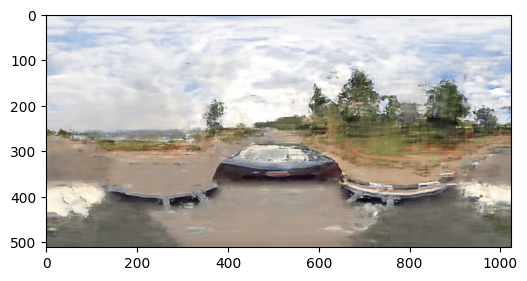

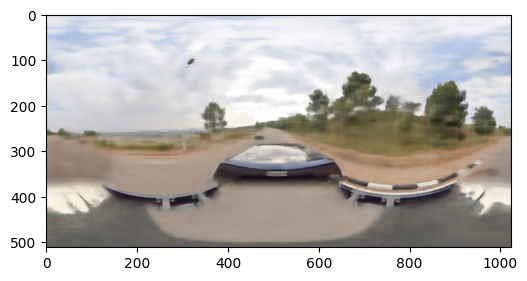

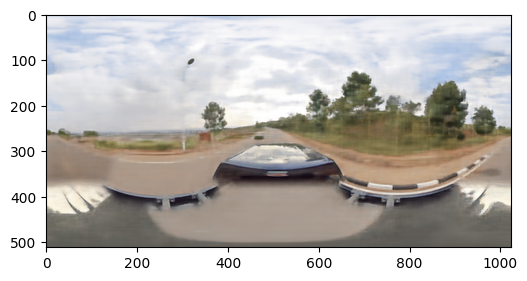

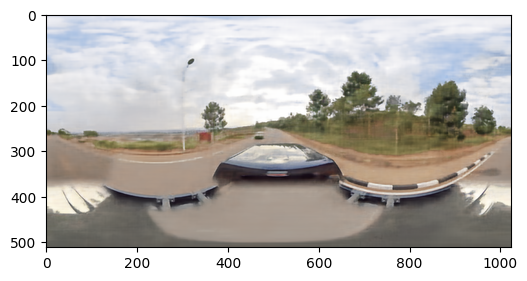

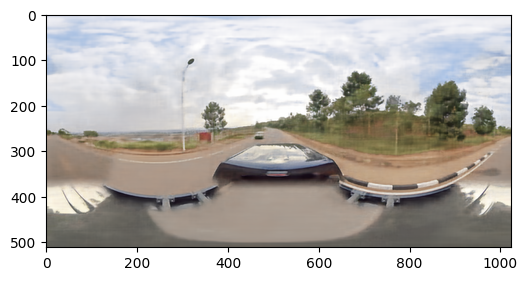

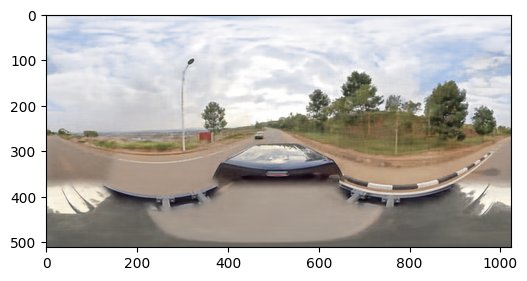

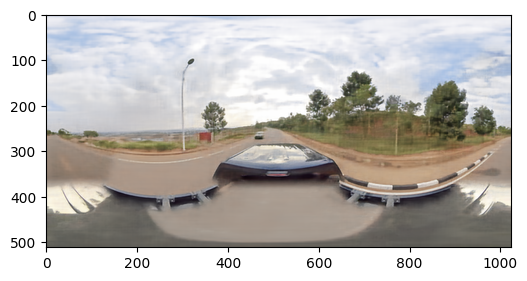

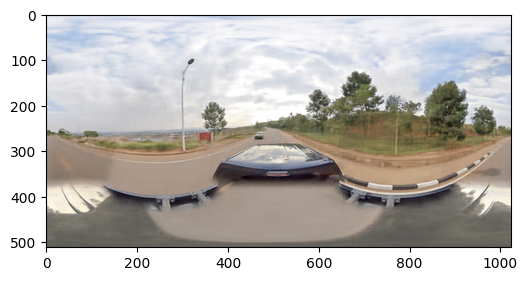

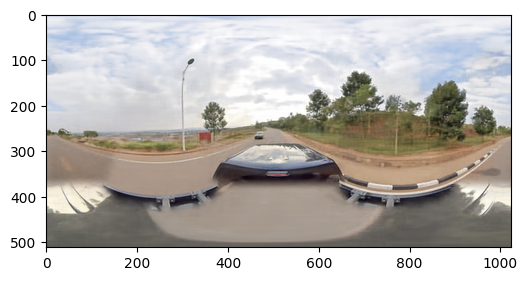

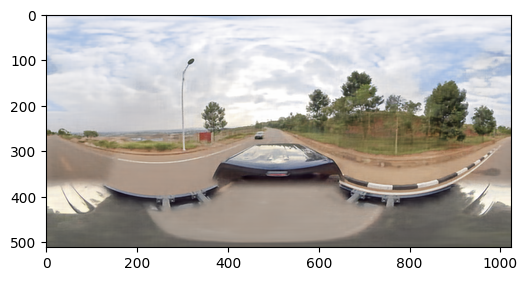

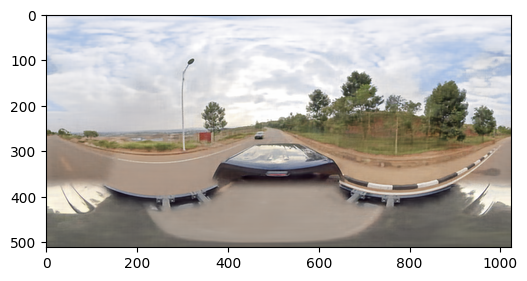

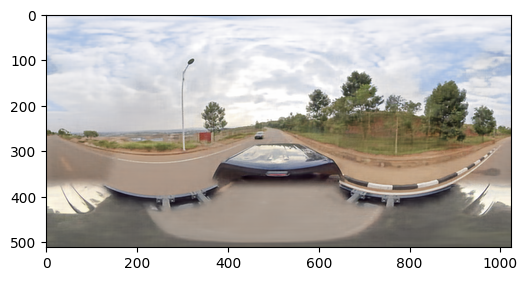

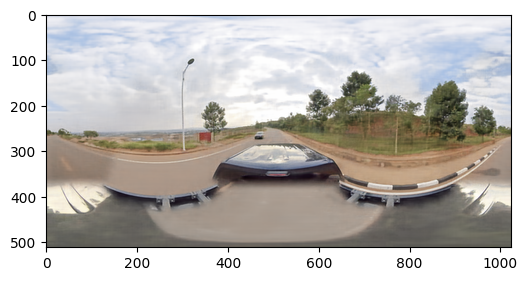

Early stopping at losses_diff:9.99378545988045e-06 < 2.5e-5
elapsed_time: 79.04247069358826


In [599]:
start_time = time.time()
i = 0

def closure():
    # Set i as global variable
    global i

    # Calculate output of the network
    out = net(img_var[:,:2,:,:])

    # Calculate total loss using a masked mean squared error
    total_loss = mse(out * mask_var, img_var * mask_var)
    total_loss.backward()
    
    # Append current total loss to the losses list
    losses_list_.append(total_loss.cpu().item())
    
    # Calculate and append the mean of differences in losses
    losses_diff_list.append(np.abs((np.array(losses_list_[-500:-1]) - np.array(losses_list_[-500:][1:]))).mean())

    # Print iteration number and current loss
    print ('Iteration %05d    Loss %f' % (i, total_loss.item()), '\r', end='')

    # Display output image grid if condition is met
    if  i % show_every == 0:
        out_np = torch_to_np(out)
        plot_image_grid([np.clip(out_np, 0, 1)], factor=figsize, nrow=1)

    i += 1
    
    return total_loss, losses_diff_list[-1]

# Save the original net input
net_input_saved = net_input.detach().clone()

# Create a copy of the net input for noise
noise = net_input.detach().clone()

# Get parameters for optimization
p = get_params('net', net, net_input)

# Optimize the network using Adam optimizer
optimize('adam', p, closure, LR, num_iter)

# Save the model checkpoint
save_model(net, path=f"{MODEL_CHECKPOINTS_PATH}{img_index}.pth")

# Save the losses list to a text file
np.savetxt(f"{img_path.split('/')[-1]}_losses.txt", losses_list_)

# Calculate and print the elapsed time
elapsed_time =  time.time() - start_time
print("elapsed_time:", elapsed_time)

In [600]:
# Save losses list to a text file in the INFERENCE_DATA_PATH directory
np.savetxt(f"{INFERENCE_DATA_PATH}{img_path.split('/')[-1]}_losses.txt", losses_list_)

In [601]:
# Convert the output tensor to a numpy array using the torch_to_np function
out_np = torch_to_np(net(img_var[:,:2,:,:]))


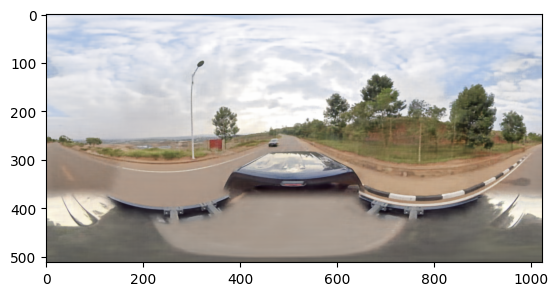

In [602]:
# Display the output image using matplotlib
plt.imshow(out_np.transpose(1,2,0))
plt.show()

# Save the output image
plt.imsave(f"{INFERENCE_DATA_PATH}{img_index}.jpg", out_np.transpose(1,2,0))

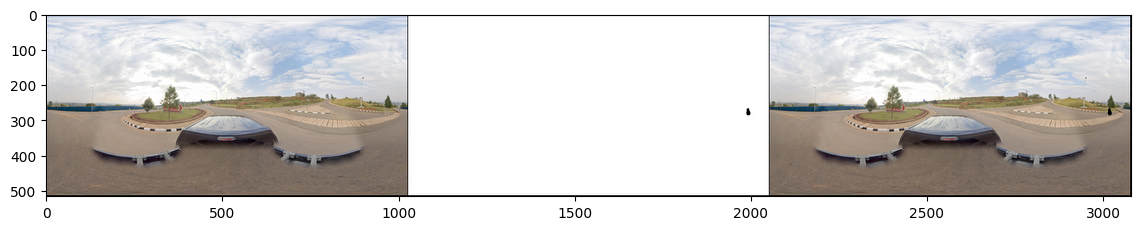

In [170]:
# Plot a grid of images including the original image, mask image, and the element-wise multiplication of the original image and mask image
dummy__ = plot_image_grid([img_var[0].cpu().numpy(), mask_var[0].cpu().numpy(),
                  img_var[0].cpu().numpy()* mask_var[0].cpu().numpy()], 3,11)


In [ ]:
# Load loss values from text files for different frames
loss_1 = np.loadtxt("/content/1.jpg_losses.txt")
loss_0 = np.loadtxt("/content/0.jpg_losses.txt")
loss_2 = np.loadtxt("/content/2.jpg_losses.txt")

Text(0, 0.5, 'MSE')

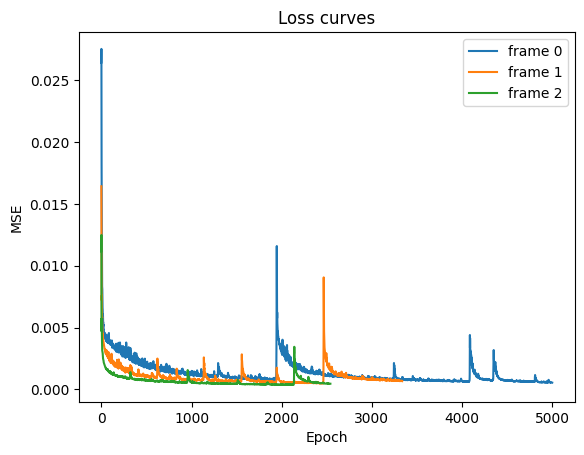

In [ ]:
# Plot the loss curves for different frames
plt.plot(loss_1, label="frame 0")
plt.plot(loss_0, label="frame 1")
plt.plot(loss_2, label="frame 2")
plt.legend()
plt.title("Loss curves")
plt.xlabel("Epoch")
plt.ylabel("MSE")